In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

In [4]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data():
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})



def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions


In [5]:
def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [6]:
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations


,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-04-27,02,Alaska,3,0.421688
1,2,2024-04-27,01,Alabama,16,0.315970
2,3,2024-04-27,05,Arkansas,30,0.986233
3,4,2024-04-27,04,Arizona,106,1.443941
4,5,2024-04-27,06,California,151,0.388309
...,...,...,...,...,...,...
6143,6144,2022-02-12,50,Vermont,0,0.000000
6144,6145,2022-02-12,53,Washington,8,0.103415
6145,6146,2022-02-12,55,Wisconsin,29,0.492275
6146,6147,2022-02-12,54,West Virginia,5,0.281694


In [154]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4

predictionsall = pd.DataFrame()
for model in models:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    print(model, len(df.location.unique()))
    
    predictionsall = pd.concat([predictionsall, df])

CADPH-FluCAT 1
CDDEP-FluCompModel 1
Ensemble 57
Ensemble_LOP 57
Ensemble_LOP_untrimmed 57
MOBS_NEU-GLEAM_FLU 52
NIH-FluD 1
NIH-Flu_TS 13
NotreDame-FRED 52
PSI-M2 52
USC-SIkJalpha 57
UT-ImmunoSEIRS 51
UVA-FluXSim 1


In [155]:
# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime(observations.date.max())]

In [24]:
full_es = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_trajensemble_rd4_hosp_521.pkl")
full_es = full_es.rename(columns={'energyscore':'energyscore_true'})[['Label', 'location', 'energyscore_true']]

In [81]:
# sample trajectories and calculate energy score

numsamps = 500
target_obs = 'hospitalization'

locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})

# include all models, even those only submitting for one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
for it in range(50):

    loclist = list(predictionsall.location.unique())

    a = list(predictionsall.trajectory_id.unique())
    samps = random.sample(a, numsamps)

    predictionssamp = predictionsall[predictionsall.trajectory_id.isin(samps) ]


    for loc in loclist:
        if loc in ['60','66','69', '72', '78']:
            continue
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            predictionsfilt = predictionssamp[(predictionssamp.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionssamp.location == location) & \
                                        (predictionssamp.target == 'inc ' + target)  & \
                                        (predictionssamp.target_end_date <= max_date) & \
                                        (predictionssamp.target_end_date >= start_week)]
            
            if len(predictionsfilt)==0:
                continue
            
            # get observations
            observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            #filter location
            observations = observations[observations['location'] == location]

            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) for i in predictionsfilt.trajectory_id.unique()]

            ES = energyscore(np.array(X),y)

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Label': 'Scenario '+ scenario, 'location':loc_conv,  
                                'target':target, 'energyscore': ES, 'numsamps':numsamps}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')



In [82]:
energyscoresdf500 = energyscoresdf.merge(full_es, on=['Label', 'location'])

In [27]:
energyscoresdf25

,Label,location,target,energyscore,numsamps,abbreviation,location_name,population,energyscore_true
0,Scenario A,6,hosp,2224.652360,25,CA,California,39512223,2408.186334
1,Scenario A,6,hosp,4139.341384,25,CA,California,39512223,2408.186334
2,Scenario A,6,hosp,2452.150543,25,CA,California,39512223,2408.186334
3,Scenario A,6,hosp,2076.363828,25,CA,California,39512223,2408.186334
4,Scenario A,6,hosp,2520.414966,25,CA,California,39512223,2408.186334
...,...,...,...,...,...,...,...,...,...
15595,Scenario F,56,hosp,83.325126,25,WY,Wyoming,578759,79.984999
15596,Scenario F,56,hosp,86.156748,25,WY,Wyoming,578759,79.984999
15597,Scenario F,56,hosp,85.015987,25,WY,Wyoming,578759,79.984999
15598,Scenario F,56,hosp,85.098466,25,WY,Wyoming,578759,79.984999


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


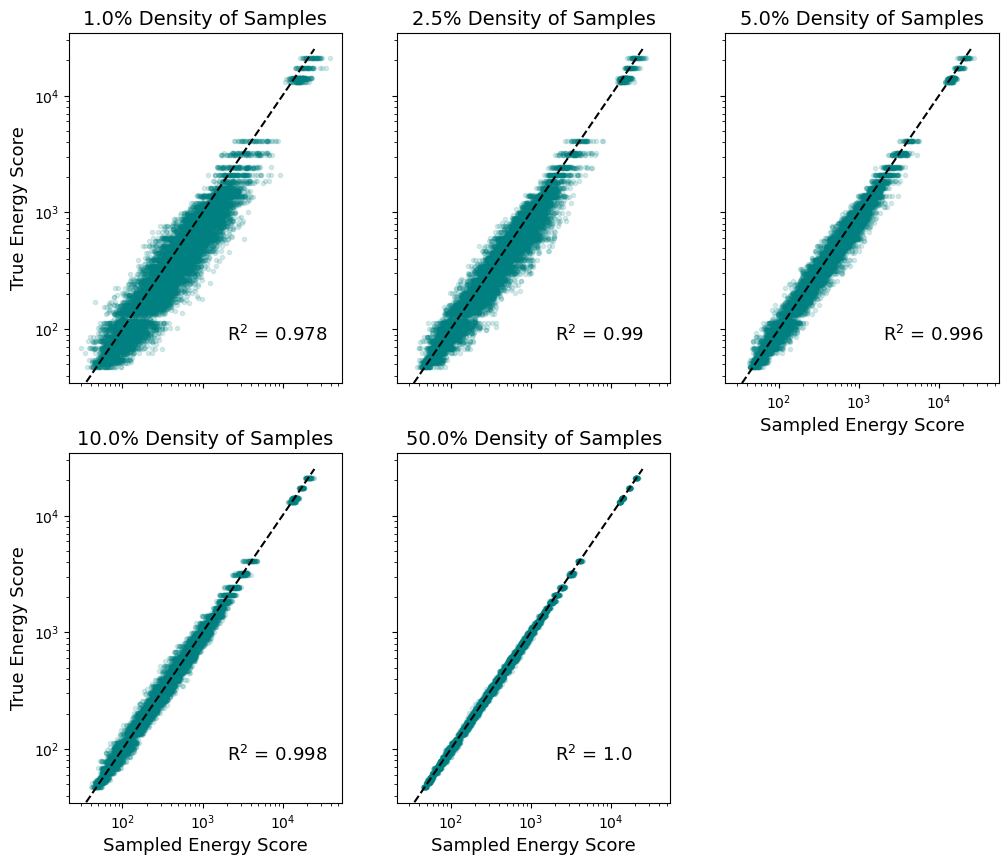

In [145]:
fig,ax = plt.subplots(2,3, figsize=(12,10), sharex=True, sharey=True)

plt.subplot(2,3,1)

plt.plot(energyscoresdf10.energyscore, energyscoresdf10.energyscore_true, '.',alpha=.15, color='teal')
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(energyscoresdf10.energyscore, 
                                                         energyscoresdf10.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(10/1000)*100}% Density of Samples', fontsize=14)
plt.ylabel('True Energy Score', fontsize=13)

plt.subplot(2,3,2)

plt.plot(energyscoresdf25.energyscore, energyscoresdf25.energyscore_true, '.',alpha=.15, color='teal')
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(energyscoresdf25.energyscore, 
                                                         energyscoresdf25.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(25/1000)*100}% Density of Samples', fontsize=14)

plt.subplot(2,3,3)

plt.plot(energyscoresdf50.energyscore, energyscoresdf50.energyscore_true, '.',alpha=.15, color='teal')
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(energyscoresdf50.energyscore, 
                                                         energyscoresdf50.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(50/1000)*100}% Density of Samples', fontsize=14)
plt.xlabel('Sampled Energy Score', fontsize=13)

plt.subplot(2,3,4)

plt.plot(energyscoresdf100.energyscore, energyscoresdf100.energyscore_true, '.',alpha=.15, color='teal')
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(energyscoresdf100.energyscore, 
                                                         energyscoresdf100.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(100/1000)*100}% Density of Samples', fontsize=14)
plt.ylabel('True Energy Score', fontsize=13)
plt.xlabel('Sampled Energy Score', fontsize=13)

plt.subplot(2,3,5)

plt.plot(energyscoresdf500.energyscore, energyscoresdf500.energyscore_true, '.',alpha=.15, color='teal')
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(energyscoresdf500.energyscore, 
                                                         energyscoresdf500.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(500/1000)*100}% Density of Samples', fontsize=14)
plt.xlabel('Sampled Energy Score', fontsize=13)

fig.delaxes(ax[1][2])
ax[0][2].tick_params(labelbottom=True)

plt.savefig('../figs/samples_flurd4.pdf')

In [83]:
energyscoresdf10.to_pickle('../fludat/energyscores_flurd4_samp10')
energyscoresdf25.to_pickle('../fludat/energyscores_flurd4_samp25')
energyscoresdf50.to_pickle('../fludat/energyscores_flurd4_samp50')
energyscoresdf100.to_pickle('../fludat/energyscores_flurd4_samp100')
energyscoresdf500.to_pickle('../fludat/energyscores_flurd4_samp500')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


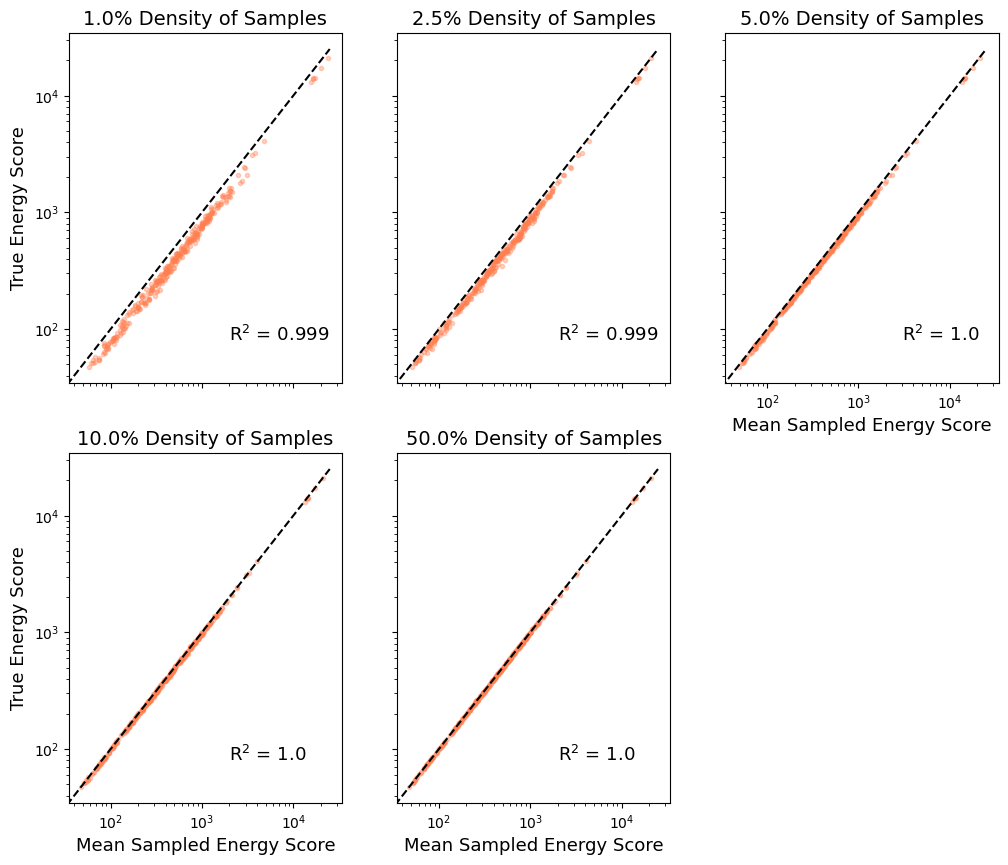

In [143]:
fig, ax = plt.subplots(2,3, figsize=(12,10), sharex=True, sharey=True)

plt.subplot(2,3,1)

df = energyscoresdf10.groupby(['Label', 'location']).mean()
plt.plot(df.energyscore, df.energyscore_true, '.',color='coral', alpha=.35)
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(df.energyscore, 
                                                        df.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(10/1000)*100}% Density of Samples', fontsize=14)
plt.ylabel('True Energy Score', fontsize=13)

plt.subplot(2,3,2)

df = energyscoresdf25.groupby(['Label', 'location']).mean()
plt.plot(df.energyscore, df.energyscore_true, '.',color='coral', alpha=.35)
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(df.energyscore, 
                                                         df.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(25/1000)*100}% Density of Samples', fontsize=14)

plt.subplot(2,3,3)

df = energyscoresdf50.groupby(['Label', 'location']).mean()
plt.plot(df.energyscore, df.energyscore_true, '.',color='coral', alpha=.35)
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(df.energyscore, 
                                                         df.energyscore_true)
    
plt.text(3000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(50/1000)*100}% Density of Samples', fontsize=14)
plt.xlabel('Mean Sampled Energy Score', fontsize=13)


plt.subplot(2,3,4)

df = energyscoresdf100.groupby(['Label', 'location']).mean()
plt.plot(df.energyscore, df.energyscore_true, '.',color='coral', alpha=.35)
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(df.energyscore, 
                                                         df.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(100/1000)*100}% Density of Samples', fontsize=14)
plt.ylabel('True Energy Score', fontsize=13)
plt.xlabel('Mean Sampled Energy Score', fontsize=13)

plt.subplot(2,3,5)

df = energyscoresdf500.groupby(['Label', 'location']).mean()
plt.plot(df.energyscore, df.energyscore_true, '.',color='coral', alpha=.35)
plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

plt.xscale("log")
plt.yscale("log")
slope, intercept, r_value, p_value, std_err = linregress(df.energyscore, 
                                                         df.energyscore_true)
    
plt.text(2000,80, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.title(f'{(500/1000)*100}% Density of Samples', fontsize=14)
plt.xlabel('Mean Sampled Energy Score', fontsize=13)
fig.delaxes(ax[1][2])
ax[0][2].tick_params(labelbottom=True)

plt.savefig('../figs/samples_avg_flurd4.pdf')

In [115]:
predictionsall[(predictionsall.trajectory_id==201) & (predictionsall.Model=='MOBS_NEU-GLEAM_FLU') &\
              (predictionsall.horizon==1.0)]

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,target_end_date,trajectory_id
0,2023-09-03,A-2023-08-14,inc hosp,1.0,01,sample,1,0-130,3.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201
3900,2023-09-03,A-2023-08-14,inc hosp,1.0,02,sample,1,0-130,1.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201
7800,2023-09-03,A-2023-08-14,inc hosp,1.0,04,sample,1,0-130,18.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201
11700,2023-09-03,A-2023-08-14,inc hosp,1.0,05,sample,1,0-130,5.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201
15600,2023-09-03,A-2023-08-14,inc hosp,1.0,06,sample,1,0-130,27.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201
...,...,...,...,...,...,...,...,...,...,...,...,...
1450800,2023-09-03,F-2023-08-14,inc hosp,1.0,53,sample,1,0-130,10.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201
1454700,2023-09-03,F-2023-08-14,inc hosp,1.0,54,sample,1,0-130,2.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201
1458600,2023-09-03,F-2023-08-14,inc hosp,1.0,55,sample,1,0-130,11.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201
1462500,2023-09-03,F-2023-08-14,inc hosp,1.0,56,sample,1,0-130,2.0,MOBS_NEU-GLEAM_FLU,2023-09-09,201


In [112]:
predictionsall.Model.unique()

array(['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU',
       'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2',
       'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim'], dtype=object)

In [117]:
predictionsall.trajectory_id.max()

1000

# Sample groups, score and look at scenarios

In [147]:
numsamps = 5

modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']
target_obs = 'hospitalization'

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    for scenario in df.scenario_id.unique():
        d = df[df.scenario_id==scenario]
        d['Model'] = model
        d['trajectory_id'] = d['output_type_id'] + 100*i 
        predictionsall = pd.concat([predictionsall, d])
        i += 1
        
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
energyscoresdf = pd.DataFrame()

ids = {}
for it in range(1500):

    loclist = list(predictionsall.location.unique())

    a = list(predictionsall.trajectory_id.unique())
    samps = random.sample(a, numsamps)
    ids[it] = samps

    predictionssamp = predictionsall[predictionsall.trajectory_id.isin(samps) ]

    

    #for loc in loclist:
    for loc in ['US']:
        #if loc in ['60','66','69', '72', '78']:
         #   continue
        
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            predictionsfilt = predictionssamp[(predictionssamp.location == location) & \
                                        (predictionssamp.target == 'inc ' + target)  & \
                                        (predictionssamp.target_end_date <= max_date) & \
                                        (predictionssamp.target_end_date >= start_week)]
            
            if len(predictionsfilt)==0:
                continue
            
            # get observations
            observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            #filter location
            observations = observations[observations['location'] == location]

            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) for i in predictionsfilt.trajectory_id.unique()]
            X = np.array(X)
            
            ES = energyscore(X,y)

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({ 'location':loc_conv,  
                                'target':target, 'energyscore': ES, 'numsamps':numsamps, 'id':it}, index=[0])
            #newrow.at[0, 'id'] = samps

            energyscoresdf = pd.concat([energyscoresdf, newrow])

In [85]:
energyscoresdf

,location,target,energyscore,numsamps,id
0,US,hosp,18786.593438,10,0
0,US,hosp,15602.631153,10,1
0,US,hosp,15982.560616,10,2
0,US,hosp,16485.998576,10,3
0,US,hosp,16277.896567,10,4
...,...,...,...,...,...
0,US,hosp,19015.010102,10,495
0,US,hosp,20262.685153,10,496
0,US,hosp,13317.898488,10,497
0,US,hosp,17076.488583,10,498


In [148]:
ESsmall = energyscoresdf.nsmallest(150, ['energyscore']) 

In [149]:
id_filt = {key: ids[key] for key in list(ESsmall.id)}

In [150]:
idlist = []
for key in id_filt.keys():
    idlist = idlist + id_filt[key]

In [151]:
scenlist = list(predictionsall[predictionsall.trajectory_id.isin(idlist)][['scenario_id', 
                               'trajectory_id']].drop_duplicates().scenario_id)

In [152]:
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count
 

x = 'A-2023-08-14'
countX(scenlist, x)

126

In [153]:
for let in ['A', 'B', 'C', 'D', 'E', 'F']:
    x = let + '-2023-08-14'
    ct = countX(scenlist, x)
    print(x + ': ' + str(ct))

A-2023-08-14: 126
B-2023-08-14: 134
C-2023-08-14: 89
D-2023-08-14: 146
E-2023-08-14: 77
F-2023-08-14: 113


# Sample only MOBS model

In [160]:
# sample trajectories and calculate energy score

#numsamps = 500
target_obs = 'hospitalization'

locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})

# include all models, even those only submitting for one location
modelsall = ['MOBS_NEU-GLEAM_FLU']

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data

predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    

for numsamps in [5,10,25,50]:
     
    for it in range(50):

        loclist = list(predictionsall.location.unique())

        a = list(predictionsall.trajectory_id.unique())
        samps = random.sample(a, numsamps)

        predictionssamp = predictionsall[predictionsall.trajectory_id.isin(samps) ]


        for loc in loclist:
            if loc in ['60','66','69', '72', '78']:
                continue
            for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
                location = loc
                target = 'hosp'
                incidence = True

                if target == 'hosp':
                    target_obs = 'hospitalization'
                else:
                    target_obs = target_obs

                predictionsfilt = predictionssamp[(predictionssamp.scenario_id == scenario + '-2023-08-14') & \
                                            (predictionssamp.location == location) & \
                                            (predictionssamp.target == 'inc ' + target)  & \
                                            (predictionssamp.target_end_date <= max_date) & \
                                            (predictionssamp.target_end_date >= start_week)]

                if len(predictionsfilt)==0:
                    continue

                # get observations
                observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
                observations['date'] = pd.to_datetime(observations['date'])

                observations = observations[(observations['date'] >= start_week) & \
                                            (observations['date'] <= max_date)]   

                #filter location
                observations = observations[observations['location'] == location]

                #aggregate to weekly
                observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

                #transform to Observation object
                observations = Observations(observations)


                y = np.array(observations.value)
                X = [np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) for i in predictionsfilt.trajectory_id.unique()]

                ES = energyscore(np.array(X),y)

                if loc == 'US':
                    loc_conv = loc
                elif int(loc) <10:
                    loc_conv = loc[1]
                else:
                    loc_conv = loc  

                newrow = pd.DataFrame({'Label': 'Scenario '+ scenario, 'location':loc_conv,  
                                    'target':target, 'energyscore': ES, 'numsamps':numsamps}, index=[0])

                energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')



In [161]:
energyscoresdf

,Label,location,target,energyscore,numsamps,abbreviation,location_name,population
0,Scenario A,1,hosp,466.086210,5,AL,Alabama,4903185
1,Scenario B,1,hosp,588.452052,5,AL,Alabama,4903185
2,Scenario C,1,hosp,464.351080,5,AL,Alabama,4903185
3,Scenario D,1,hosp,493.366111,5,AL,Alabama,4903185
4,Scenario E,1,hosp,511.505959,5,AL,Alabama,4903185
...,...,...,...,...,...,...,...,...
62395,Scenario B,US,hosp,26348.539424,50,US,US,328728466
62396,Scenario C,US,hosp,25005.636770,50,US,US,328728466
62397,Scenario D,US,hosp,24867.396506,50,US,US,328728466
62398,Scenario E,US,hosp,22282.598598,50,US,US,328728466


In [162]:
energyscoresdf.to_pickle('../fludat/MOBS_sampled.pkl')

In [163]:
# full energy score
energyscoresdf_true = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


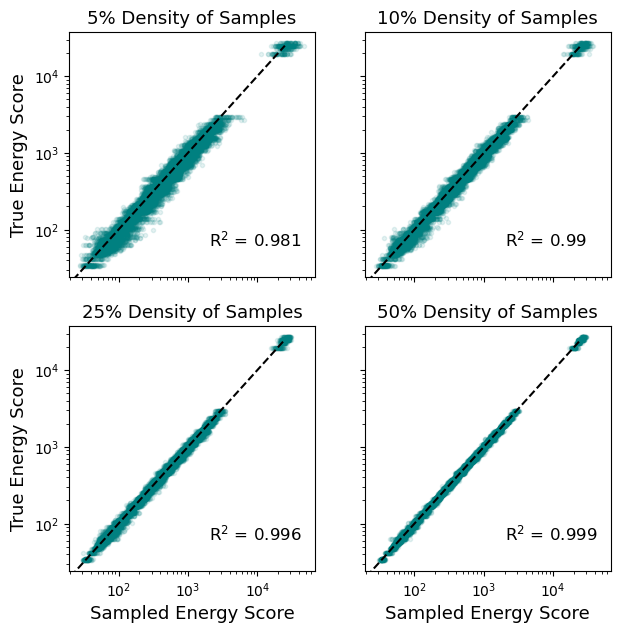

In [185]:
# full energy score
energyscoresdf_true = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf_true = energyscoresdf_true[energyscoresdf_true.Model == 'MOBS_NEU-GLEAM_FLU']
energyscoresdf_true = energyscoresdf_true.rename(columns={'energyscore':'energyscore_true'})
energyscoresdf_samp = pd.read_pickle('../fludat/MOBS_sampled.pkl').rename(columns={'energyscore':'energyscore_samp'})


ESdf = energyscoresdf_samp.merge(energyscoresdf_true, on=['location', 'Label', 'abbreviation', 'location_name', 
                                                   'population', 'target'])


fig,ax = plt.subplots(2,2, figsize=(7,7), sharex=True, sharey=True)

i=1
for numsamp in ESdf.numsamps.unique():

    plt.subplot(2,2,i)
    
    df = ESdf[ESdf.numsamps == numsamp]

    plt.plot(df.energyscore_samp, df.energyscore_true, '.',alpha=.1, color='teal')
    plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='k', linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    slope, intercept, r_value, p_value, std_err = linregress(df.energyscore_samp, 
                                                             df.energyscore_true)

    plt.text(2000,60, r'R$^2$ = '+str(round(r_value, 3)), fontsize=12)
    plt.title(f'{int((numsamp/100)*100)}% Density of Samples', fontsize=13)
    
    if i in [1,3]:
        plt.ylabel('True Energy Score', fontsize=13)
    
    if i in [3,4]:
        plt.xlabel('Sampled Energy Score', fontsize=13)

    i+=1
plt.savefig('../figs/samples_flurd4_MOBS.pdf')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


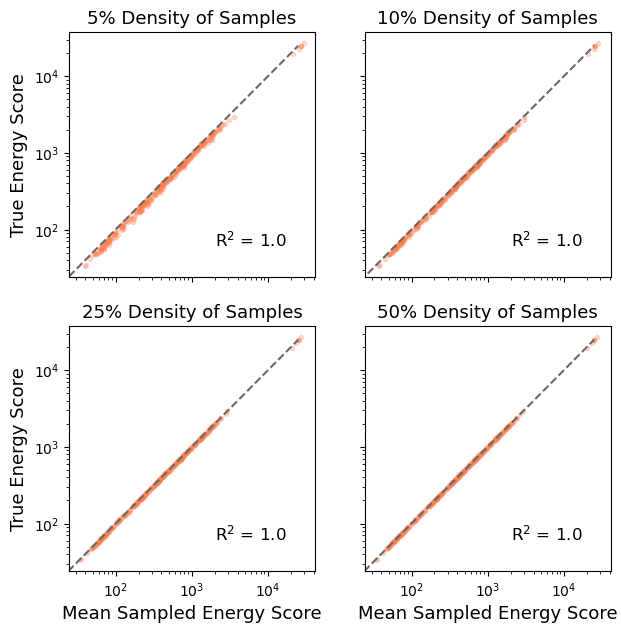

In [191]:
# full energy score
energyscoresdf_true = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf_true = energyscoresdf_true[energyscoresdf_true.Model == 'MOBS_NEU-GLEAM_FLU']
energyscoresdf_true = energyscoresdf_true.rename(columns={'energyscore':'energyscore_true'})
energyscoresdf_samp = pd.read_pickle('../fludat/MOBS_sampled.pkl').rename(columns={'energyscore':'energyscore_samp'})


ESdf = energyscoresdf_samp.merge(energyscoresdf_true, on=['location', 'Label', 'abbreviation', 'location_name', 
                                                   'population', 'target'])


fig,ax = plt.subplots(2,2, figsize=(7,7), sharex=True, sharey=True)

i=1
for numsamp in ESdf.numsamps.unique():

    plt.subplot(2,2,i)
    
    df = ESdf[ESdf.numsamps == numsamp]
    df = df.groupby(['Label', 'location']).mean()

    plt.plot(df.energyscore_samp, df.energyscore_true, '.',alpha=.25, color='coral')
    plt.plot(np.linspace(0, 25000, 100), np.linspace(0, 25000, 100), color='dimgray', linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    slope, intercept, r_value, p_value, std_err = linregress(df.energyscore_samp, 
                                                             df.energyscore_true)

    plt.text(2000,60, r'R$^2$ = '+str(round(r_value, 3)), fontsize=12)
    plt.title(f'{int((numsamp/100)*100)}% Density of Samples', fontsize=13)
    
    if i in [1,3]:
        plt.ylabel('True Energy Score', fontsize=13)
    
    if i in [3,4]:
        plt.xlabel('Mean Sampled Energy Score', fontsize=13)

    i+=1
plt.savefig('../figs/samples_avg_flurd4_MOBS.pdf')

In [186]:
df 

,Label,location,target,energyscore_samp,numsamps,abbreviation,location_name,population,Model,energyscore_true
150,Scenario A,1,hosp,424.868891,50,AL,Alabama,4903185,MOBS_NEU-GLEAM_FLU,426.430823
151,Scenario A,1,hosp,444.775296,50,AL,Alabama,4903185,MOBS_NEU-GLEAM_FLU,426.430823
152,Scenario A,1,hosp,421.131089,50,AL,Alabama,4903185,MOBS_NEU-GLEAM_FLU,426.430823
153,Scenario A,1,hosp,422.394356,50,AL,Alabama,4903185,MOBS_NEU-GLEAM_FLU,426.430823
154,Scenario A,1,hosp,435.524642,50,AL,Alabama,4903185,MOBS_NEU-GLEAM_FLU,426.430823
...,...,...,...,...,...,...,...,...,...,...
62395,Scenario F,US,hosp,19538.526632,50,US,US,328728466,MOBS_NEU-GLEAM_FLU,19737.391147
62396,Scenario F,US,hosp,20962.806335,50,US,US,328728466,MOBS_NEU-GLEAM_FLU,19737.391147
62397,Scenario F,US,hosp,22813.431469,50,US,US,328728466,MOBS_NEU-GLEAM_FLU,19737.391147
62398,Scenario F,US,hosp,19540.565390,50,US,US,328728466,MOBS_NEU-GLEAM_FLU,19737.391147
